In [1]:
# # !!! only uncomment and run when using colab !!!
# import os
# ! git clone https://github.com/Plant-Root-Soil-Interactions-Modelling/CPlantBox # downloading the source code
# os.chdir("/content/CPlantBox/")
# ! git pull
# ! cmake .
# ! make
# os.chdir("/content/CPlantBox/tutorial/jupyter/UQ_15_08_2022/")

# UQ presentation - 2022 - coupled carbon and water flow in CPlantBox

## Simulation of water and carbon movement 


In the following we will show how to compute the couple water and carbo flow in the plant. 



We consider dynamic plant and a static soil. 
To compute the water xylem flux we use the hybrid analytical approach of Meunier et al. (2017). To compute the photosynthesis rate, we use the Leuning methode, as presented by Tuzet et al. (2003). To compute the carbon flux, we use the code developped by Lacointe et al. (2019).

**Reference**

F Meunier, X Draye, J Vanderborght, M Javaux, V Couvreur. A hybrid analytical-numerical method for solving water flow equations in root hydraulic architectures. *Applied Mathematical modelling*, 2017.

A Tuzet, A Perrier, R Leuning. A coupled model of stomatal conductance, photosynthesis and transpiration. *Plant, Cell & Environment*, 2003.

A Lacointe and P. Minchin. A mechanistic model to predict distribution of carbon among multiple sinks. *Methods in molecular biology* (Clifton, N.J.) vol. 2014, 2019.
	

In [97]:
import sys; sys.path.append("../../.."); sys.path.append("../../../src/python_modules")
import plantbox as pb
from xylem_flux import XylemFluxPython  # Python hybrid solver
import numpy as np
import vtk_plot as vp # for quick 3d vizualisations
import matplotlib.pyplot as plt
from phloem_flux import PhloemFluxPython  


## 1. Define environmental variabes



In [98]:

def div0(a, b, c):        
    return np.divide(a, b, out=np.full(len(a), c), where=b!=0)
    
def div0f(a, b, c):    
    if b != 0:
        return a/b
    else:
        return a/c
        
def theta2H(vg,theta):#(-) to cm
    thetar =vg[0] 
    thetas = vg[1] 
    alpha = vg[2] 
    n = vg[3] 
    nrev = 1/(1-1/n)
    H =-(((( (thetas - thetar)/(theta - thetar))**nrev) - 1)**(1/n))/alpha
    return(H)#cm

def sinusoidal(t):
    return (np.sin(np.pi*t*2)+1)/2

def qair2rh(qair, es_, press):
    e =qair * press / (0.378 * qair + 0.622)
    rh = e / es_
    rh=max(min(rh, 1.),0.)
    return rh


def weather(simDuration):
    vgSoil = [0.059, 0.45, 0.00644, 1.503, 1]
    
    Qmin = 0; Qmax = 960e-6 #458*2.1
    Tmin = 15.8; Tmax = 22
    specificHumidity = 0.0097
    Pair = 1010.00 #hPa
    thetaInit = 30/100

    coefhours = sinusoidal(simDuration)
    TairC_ = Tmin + (Tmax - Tmin) * coefhours
    Q_ = Qmin + (Qmax - Qmin) * coefhours
    cs = 850e-6 #co2 paartial pressure at leaf surface (mol mol-1)
    es =  6.112 * np.exp((17.67 * TairC_)/(TairC_ + 243.5))
    RH = qair2rh(specificHumidity, es, Pair)
    
    pmean = theta2H(vgSoil, thetaInit)
    
    weatherVar = {'TairC' : TairC_,
                    'Qlight': Q_,
                    'cs':cs, 'RH':RH, 'p_mean':pmean, 'vg':vgSoil}
    return weatherVar

## 2. Define xylem and phloem shape

In [99]:

def setKrKx_xylem(TairC, RH): #inC
    #mg/cm3
    hPa2cm = 1.0197
    dEauPure = (999.83952 + TairC * (16.952577 + TairC * 
        (- 0.0079905127 + TairC * (- 0.000046241757 + TairC * 
        (0.00000010584601 + TairC * (- 0.00000000028103006)))))) /  (1 + 0.016887236 * TairC)
    siPhi = (30 - TairC) / (91 + TairC)
    siEnne=0
    mu =  pow(10, (- 0.114 + (siPhi * (1.1 + 43.1 * pow(siEnne, 1.25) )))) 
    mu = mu /(24*60*60)/100/1000; #//mPa s to hPa d, 1.11837e-10 hPa d for pure water at 293.15K
    mu = mu * hPa2cm #hPa d to cmh2o d 

    #number of vascular bundles
    VascBundle_leaf = 32
    VascBundle_stem = 52
    VascBundle_root = 1 #valid for all root type
            
    #radius of xylem type^4 * number per bundle
    rad_x_l_1   = (0.0015 **4) * 2; rad_x_l_2   = (0.0005 **4) * 2   
    rad_x_s_1   = (0.0017 **4) * 3; rad_x_s_2   = (0.0008 **4) * 1     
    rad_x_r0_1  = (0.0015 **4) * 4    
    rad_x_r12_1 = (0.00041**4) * 4; rad_x_r12_2 = (0.00087**4) * 1
    rad_x_r3_1  = (0.00068**4) * 1      

    # axial conductivity [cm^3/day]        
    kz_l  = VascBundle_leaf *(rad_x_l_1 + rad_x_l_2)    *np.pi /(mu * 8)  
    kz_s  = VascBundle_stem *(rad_x_s_1 + rad_x_s_2)    *np.pi /(mu * 8) 
    kz_r0 = VascBundle_root * rad_x_r0_1                *np.pi /(mu * 8)  
    kz_r1 = VascBundle_root *(rad_x_r12_1 + rad_x_r12_2)*np.pi /(mu * 8) 
    kz_r2 = VascBundle_root *(rad_x_r12_1 + rad_x_r12_2)*np.pi /(mu * 8)  
    kz_r3 = VascBundle_root * rad_x_r3_1                *np.pi /(mu * 8) # 4.32e-1

    #radial conductivity [1/day],
    kr_l  = 3.83e-4 * hPa2cm# init: 3.83e-4 cm/d/hPa
    kr_s  = 0.#1.e-20  * hPa2cm # set to almost 0
    kr_r0 = 6.37e-5 * hPa2cm 
    kr_r1 = 7.9e-5  * hPa2cm 
    kr_r2 = 7.9e-5  * hPa2cm  
    kr_r3 = 6.8e-5  * hPa2cm 
    l_kr = 0.8 #cm
    r.setKr([[kr_r0,kr_r1,kr_r2,kr_r0],[kr_s,kr_s ],[kr_l]], kr_length_=l_kr) 
    r.setKx([[kz_r0,kz_r1,kz_r2,kz_r0],[kz_s,kz_s ],[kz_l]])
    
    
    Rgaz=8.314 #J K-1 mol-1 = cm^3*MPa/K/mol
    rho_h2o = dEauPure/1000#g/cm3
    Mh2o = 18.05 #g/mol
    MPa2hPa = 10000
    hPa2cm = 1/0.9806806
    #log(-) * (cm^3*MPa/K/mol) * (K) *(g/cm3)/ (g/mol) * (hPa/MPa) * (cm/hPa) =  cm                      
    p_a = np.log(RH) * Rgaz * rho_h2o * (TairC + 273.15)/Mh2o * MPa2hPa * hPa2cm

    r.psi_air = p_a #*MPa2hPa #used only with xylem

    
def setKrKx_phloem(): #inC

    #number of vascular bundles
    VascBundle_leaf = 32
    VascBundle_stem = 52
    VascBundle_root = 1 #valid for all root type
            
    #numPerBundle
    numL = 18
    numS = 21
    numr0 = 33
    numr1 = 25
    numr2 = 25
    numr3 = 1
        
    #radius of phloem type^4 * number per bundle
    rad_s_l   = numL* (0.00025 **4)# * 2; rad_x_l_2   = (0.0005 **4) * 2   
    rad_s_s   = numS *(0.00019 **4) #* 3; rad_x_s_2   = (0.0008 **4) * 1     
    rad_s_r0  = numr0 *(0.00039 **4) #* 4    
    rad_s_r12 = numr1*(0.00035**4) #* 4; rad_x_r12_2 = (0.00087**4) * 1
    rad_s_r3  = numr3 *(0.00068**4) #* 1      

    # axial conductivity [cm^3/day] , mu is added later as it evolves with CST  
    beta = 0.9 #Thompson 2003a
    kz_l   = VascBundle_leaf * rad_s_l   * np.pi /8 * beta  
    kz_s   = VascBundle_stem * rad_s_s   * np.pi /8 * beta
    kz_r0  = VascBundle_root * rad_s_r0  * np.pi /8 * beta
    kz_r12 = VascBundle_root * rad_s_r12 * np.pi /8 * beta
    kz_r3  = VascBundle_root * rad_s_r3  * np.pi /8 * beta
    
    
    #radial conductivity [1/day],
    kr_l  = 0.#3.83e-4 * hPa2cm# init: 3.83e-4 cm/d/hPa
    kr_s  = 0.#1.e-20  * hPa2cm # set to almost 0
    kr_r0 = 5e-2
    kr_r1 = 5e-2
    kr_r2 = 5e-2
    kr_r3 = 5e-2
    l_kr = 0.8 #cm
    
    r.setKr_st([[kr_r0,kr_r1 ,kr_r2 ,kr_r0],[kr_s,kr_s ],[kr_l]] , kr_length_= l_kr)
    r.setKx_st([[kz_r0,kz_r12,kz_r12,kz_r0],[kz_s,kz_s ],[kz_l]])
    
    a_ST = [[0.00039,0.00035,0.00035,0.00039 ],[0.00019,0.00019],[0.00025]]
    Across_s_l   = numL*VascBundle_leaf *(a_ST[2][0]**2)*np.pi
    Across_s_s   = numS *VascBundle_stem * (a_ST[1][0]**2)*np.pi     
    Across_s_r0  = numr0 *VascBundle_root * (a_ST[0][0]**2)*np.pi#(0.00039 **2) #* 4    
    Across_s_r12 = numr1*VascBundle_root * (a_ST[0][1]**2)*np.pi#(0.00035**2) #* 4; rad_x_r12_2 = (0.00087**4) * 1
    Across_s_r3  =  numr3 *VascBundle_root *(a_ST[0][2]**2)*np.pi# (0.00068**2) #* 1    
    
    Perimeter_s_l   = numL*VascBundle_leaf *(a_ST[2][0])* 2 * np.pi# (0.00025 **2)# * 2; rad_x_l_2   = (0.0005 **4) * 2   
    Perimeter_s_s   = numS *VascBundle_stem * (a_ST[1][0])* 2 * np.pi#(0.00019 **2) #* 3; rad_x_s_2   = (0.0008 **4) * 1     
    Perimeter_s_r0  = numr0 *VascBundle_root * (a_ST[0][0])* 2 * np.pi#(0.00039 **2) #* 4    
    Perimeter_s_r12 = numr1*VascBundle_root * (a_ST[0][1])* 2 * np.pi#(0.00035**2) #* 4; rad_x_r12_2 = (0.00087**4) * 1
    Perimeter_s_r3  =  numr3 *VascBundle_root *(a_ST[0][2])* 2 * np.pi# (0.00068**2) #* 1  
    r.setAcross_st([[Across_s_r0,Across_s_r12,Across_s_r12,Across_s_r0],[Across_s_s,Across_s_s],[Across_s_l]])

## 3. Define initial conditions

In [139]:

weatherInit = weather(0)
simDuration = 7 # [day] init simtime
simMax = 8
dt =1/24
depth = 60
verbose = False

#for post-processing
Q_in  = 0
Q_out = 0
AnSum = 0
filename = "phloemoutputs.txt" 

Q_Rmbu      = np.array([0.])
Q_Grbu      = np.array([0.])
Q_Exudbu    = np.array([0.])

Q_Rmall      = np.array([])
Q_Grall     = np.array([])
Q_Exudall    = np.array([])
time = np.array([])

# plant system 
pl = pb.MappedPlant(seednum = 2) 
path = "../../../modelparameter/plant/"
name = "Triticum_aestivum_adapted_2021"
pl.readParameters(path + name + ".xml")

sdf = pb.SDF_PlantBox(np.Inf, np.Inf, depth )
pl.setGeometry(sdf) # creates soil space to stop roots from growing out of the soil


pl.initialize(verbose )
pl.simulate(simDuration, False)
Nt = len(r.plant.nodes) 
Ntbu = 1

## 4. Define static soil

In [140]:

min_b = [-3./2, -12./2, -61.]#distance between wheat plants
max_b = [3./2, 12./2, 0.]
cell_number = [6, 24, 61]#1cm3? 
layers = depth; soilvolume = (depth / layers) * 3 * 12
k_soil = []
p_mean = -187
p_bot = p_mean + depth/2
p_top = p_mean - depth/2
sx = np.linspace(p_top, p_bot, depth)

picker = lambda x,y,z : max(int(np.floor(-z)),-1) 
pl.setSoilGrid(picker)  # maps segment


## 5. create object to compute carbon and water flux

In [141]:

r = PhloemFluxPython(pl,psiXylInit = min(sx),ciInit = weatherInit["cs"]*0.5)


## 6. set other parameters and initial variable

In [142]:
#for photosynthesis
r.g0 = 8e-3
r.VcmaxrefChl1 =1.28#/2
r.VcmaxrefChl2 = 8.33#/2
r.a1 = 0.5#0#0.6/0.4#0.7/0.3#0.6/0.4 #ci/(cs - ci) for ci = 0.6*cs
r.a3 = 1.5
r.alpha = 0.4#0.2#/2
r.theta = 0.6#0.9#/2
r.cs = weatherInit["cs"]
SPAD= 41.0
chl_ = (0.114 *(SPAD**2)+ 7.39 *SPAD+ 10.6)/10
r.Chl = np.array( [chl_]) 

#for phloem flow
setKrKx_phloem()
r.k_meso = 1e-3#1e-4
r.setKrm2([[2e-5]])
r.setKrm1([[10e-2]])#([[2.5e-2]])
r.setRhoSucrose([[0.51],[0.65],[0.56]])#0.51
r.setRmax_st([[14.4,9.0,6.0,14.4],[5.,5.],[15.]])#\
r.KMfu = 0.1#VERY IMPORTANT TO KEEP IT HIGH
r.sameVolume_meso_st = False
r.sameVolume_meso_seg = True
r.withInitVal =False
r.initValST = 0#0.6
r.initValMeso = 0#0.9
r.beta_loading = 0.6
r.Vmaxloading = 0.05 #mmol/d, needed mean loading rate:  0.3788921068507634
r.Mloading = 0.2
r.Gr_Y = 0.8
r.CSTimin = 0.4
r.surfMeso=0.0025
r.Csoil = 1e-4



r.expression = 6
r.update_viscosity = True
r.solver = 1
r.atol = 1e-12
r.rtol = 1e-8


In [143]:

while simDuration <= simMax: 
    
    print('simDuration:',simDuration )
    Nt = len(r.plant.nodes) 
    weatherX = weather(simDuration)
    r.Qlight = weatherX["Qlight"] #
    setKrKx_xylem(weatherX["TairC"], weatherX["RH"])
    
    
    r.solve_photosynthesis(sim_time_ = simDuration, sxx_=sx, cells_ = True,RH_ = weatherX["RH"],
        verbose_ = False, doLog_ = False,TairC_= weatherX["TairC"] )
    
    
    AnSum += np.sum(r.Ag4Phloem)*dt
    
    startphloem= simDuration
    endphloem = startphloem + dt
    stepphloem = 1
    
    errLeuning = sum(r.outputFlux)
    fluxes = np.array(r.outputFlux)
    fluxesSoil = r.soilFluxes(simDuration, r.psiXyl, sx, approx=False)
    
    
    r.startPM(startphloem, endphloem, stepphloem, ( weatherX["TairC"]  +273.15) , True, filename)
        
        
    Q_ST    = np.array(r.Q_out[0:Nt])
    Q_meso  = np.array(r.Q_out[Nt:(Nt*2)])
    Q_Rm    = np.array(r.Q_out[(Nt*2):(Nt*3)])
    Q_Exud  = np.array(r.Q_out[(Nt*3):(Nt*4)])
    Q_Gr    = np.array(r.Q_out[(Nt*4):(Nt*5)])
    
    C_ST    = np.array(r.C_ST)
    Fl      = np.array(r.Fl)
    volST   = np.array(r.vol_ST)
    volMeso   = np.array(r.vol_Meso)
    C_meso  = Q_meso/volMeso
    Q_in   += sum(np.array(r.AgPhl)*dt)
    Q_out   = Q_Rm + Q_Exud + Q_Gr
    error   = sum(Q_ST + Q_meso + Q_out )- Q_in 
    
    delta_ls_i = np.array(r.delta_ls_org_i)
    delta_ls = np.array(r.delta_ls_org)
    
    Q_ST_i        = Q_ST      - Q_STbu
    Q_Rm_i        = Q_Rm      - Q_Rmbu
    Q_Gr_i        = Q_Gr      - Q_Grbu
    Q_Exud_i      = Q_Exud    - Q_Exudbu
    Q_out_i       = Q_Rm_i    + Q_Exud_i      + Q_Gr_i
    
    
    orgs = r.plant.getOrgans(-1, True)
    id_orgs = np.array([org.getId() for org in orgs])
    orgs_all = r.plant.getOrgans(-1, True)
    ot_orgs_all = np.array([org.organType() for org in orgs_all])
    
    print("\n\n\n\t\tat ", int(np.floor(simDuration)),"d", int((simDuration%1)*24),"h",  round(r.Qlight *1e6),"mumol m-2 s-1")
    print("Error in Suc_balance:\n\tabs (mmol) {:5.2e}\trel (-) {:5.2e}".format(error, div0f(error,Q_in, 1.)))
    print("Error in photos:\n\tabs (cm3/day) {:5.2e}".format(errLeuning))
    print("water fluxes (cm3/day):\n\ttrans {:5.2e}\tminExud {:5.2e}\tmaxExud {:5.2e}".format(sum(fluxesSoil.values()), min(fluxesSoil.values()), max(fluxesSoil.values())))
    print("assimilated Sucrose (cm)\tAn {:5.2e}".format(AnSum) 
    print("sucrose concentration in sieve tube (mmol ml-1):\n\tmean {:.2e}\tmin  {:5.2e} at {:d} segs \tmax  {:5.2e}".format(np.mean(C_ST), min(C_ST), len(np.where(C_ST == min(C_ST) )[0]), max(C_ST)))        
    print('cumulatede \tRm   {:.2e}\tGr   {:.2e}\tExud {:5.2e}'.format(sum(Q_Rm), sum(Q_Gr), sum(Q_Exud)))
    print("aggregated sink repartition at last time step (%) :\n\tRm   {:5.1f}\tGr   {:5.1f}\tExud {:5.1f}".format(sum(Q_Rm_i)/sum(Q_out_i)*100, 
         sum(Q_Gr_i)/sum(Q_out_i)*100,sum(Q_Exud_i)/sum(Q_out_i)*100))
    print("total aggregated sink repartition (%) :\n\tRm   {:5.1f}\tGr   {:5.1f}\tExud {:5.1f}".format(sum(Q_Rm)/sum(Q_out)*100, 
         sum(Q_Gr)/sum(Q_out)*100,sum(Q_Exud)/sum(Q_out)*100))
    print("growth (cm)\ttot {:5.2e}\ti {:5.2e}".format(sum(delta_ls), sum(delta_ls_i)))      
    
    r.plant.simulate(dt, False)
    simDuration += dt
    
    Ntbu = Nt
    Nt = len(r.plant.nodes)
    Q_Rmbu       =   np.concatenate((Q_Rm, np.full(Nt - Ntbu, 0.)))
    Q_Grbu       =   np.concatenate((Q_Gr, np.full(Nt - Ntbu, 0.))) 
    Q_Exudbu     =   np.concatenate((Q_Exud, np.full(Nt - Ntbu, 0.))) 
    
    
    Q_Rmall    = np.append( Q_Rmall  ,sum(Q_Rm_i))
    Q_Grall    = np.append( Q_Grall  ,sum(Q_Gr_i))
    Q_Exudall  = np.append( Q_Exudall,sum(Q_Exud_i))
    time       = np.append( time ,simDuration)
    


simDuration: 7



		at  7 d 0 h 480 mumol m-2 s-1
Error in Suc_balance:
	abs (mmol) -8.89e-15	rel (-) -6.29e-13
Error in photos:
	abs (cm3/day) -7.44e-11
water fluxes (cm3/day):
	trans -1.56e-02	minExud -5.18e-03	maxExud 0.00e+00
C_ST (mmol ml-1):
	mean 3.66e-01	min  3.62e-01 at 1 segs 	max  3.83e-01
C_me (mmol ml-1):
	mean 4.03e-03	min  -0.00e+00	max  3.76e-02
Q_X (mmol Suc): 
	ST   1.93e-03	meso 1.22e-02	in   1.41e-02
	Rm   0.00e+00	Gr   0.00e+00	Exud 0.00e+00
aggregated sink satisfaction at last time step (%) :
	tot    0.0
	Rm     0.0	Gr     0.0	Exud   0.0
aggregated sink repartition at last time step (%) :
	Rm     nan	Gr     nan	Exud   nan
aggregated sink repartition (%) :
	Rm     nan	Gr     nan	Exud   nan
aggregated sink repartition for max (%) :
	Rm    13.7	Gr    79.3	Exud   7.0
abs val for max :
	Rm   0.00431	Gr   0.02489	Exud 0.00220
Q_Par 0.00e+00, C_Par 0.00e+00
growth (cm)	tot 3.11e-15	i 3.11e-15
max growth (cm)	tot 4.44e+00	i 4.44e+00
amount Suc (cm)	An 1.41e-02	Gr 0.00e+00

/tmp/ipykernel_1966/2385631729.py:91: RuntimeWarning: invalid value encountered in double_scalars
  print("aggregated sink repartition at last time step (%) :\n\tRm   {:5.1f}\tGr   {:5.1f}\tExud {:5.1f}".format(sum(Q_Rm_i)/sum(Q_out_i)*100,
/tmp/ipykernel_1966/2385631729.py:92: RuntimeWarning: invalid value encountered in double_scalars
  sum(Q_Gr_i)/sum(Q_out_i)*100,sum(Q_Exud_i)/sum(Q_out_i)*100))
/tmp/ipykernel_1966/2385631729.py:93: RuntimeWarning: invalid value encountered in double_scalars
  print("aggregated sink repartition (%) :\n\tRm   {:5.1f}\tGr   {:5.1f}\tExud {:5.1f}".format(sum(Q_Rm)/sum(Q_out)*100,
/tmp/ipykernel_1966/2385631729.py:94: RuntimeWarning: invalid value encountered in double_scalars
  sum(Q_Gr)/sum(Q_out)*100,sum(Q_Exud)/sum(Q_out)*100))


 mumol m-2 s-1
Error in Suc_balance:
	abs (mmol) -1.63e-14	rel (-) -5.69e-13
Error in photos:
	abs (cm3/day) 1.28e-12
water fluxes (cm3/day):
	trans -1.90e-02	minExud -6.29e-03	maxExud 0.00e+00
C_ST (mmol ml-1):
	mean 4.20e-01	min  4.13e-01 at 1 segs 	max  4.46e-01
C_me (mmol ml-1):
	mean 7.50e-03	min  -0.00e+00	max  7.00e-02
Q_X (mmol Suc): 
	ST   2.22e-03	meso 2.27e-02	in   2.87e-02
	Rm   2.24e-03	Gr   1.54e-03	Exud 2.43e-05
aggregated sink satisfaction at last time step (%) :
	tot    5.9
	Rm    25.3	Gr     3.0	Exud   0.6
aggregated sink repartition at last time step (%) :
	Rm    59.0	Gr    40.4	Exud   0.6
aggregated sink repartition (%) :
	Rm    59.0	Gr    40.4	Exud   0.6
aggregated sink repartition for max (%) :
	Rm    13.7	Gr    79.5	Exud   6.8
abs val for max :
	Rm   0.00887	Gr   0.05136	Exud 0.00440
Q_Par 0.00e+00, C_Par 0.00e+00
growth (cm)	tot 4.32e-01	i 4.32e-01
max growth (cm)	tot 9.22e+00	i 4.77e+00
amount Suc (cm)	An 2.87e-02	Gr 1.23e-03	RGr 3.07e-04	Rm 2.24e-03	Exud 2.43e

		at  7 d 9 h 819 mumol m-2 s-1
Error in Suc_balance:
	abs (mmol) -8.12e-14	rel (-) -5.30e-13
Error in photos:
	abs (cm3/day) -8.51e-11
water fluxes (cm3/day):
	trans -2.56e-02	minExud -7.83e-03	maxExud 0.00e+00
C_ST (mmol ml-1):
	mean 4.48e-01	min  4.34e-01 at 1 segs 	max  5.01e-01
C_me (mmol ml-1):
	mean 2.36e-02	min  -0.00e+00	max  2.48e-01
Q_X (mmol Suc): 
	ST   2.45e-03	meso 8.03e-02	in   1.53e-01
	Rm   3.04e-02	Gr   3.94e-02	Exud 6.61e-04
aggregated sink satisfaction at last time step (%) :
	tot    3.1
	Rm     7.1	Gr     2.5	Exud   0.5
aggregated sink repartition at last time step (%) :
	Rm    35.1	Gr    63.7	Exud   1.2
aggregated sink repartition (%) :
	Rm    43.2	Gr    55.9	Exud   0.9
aggregated sink repartition for max (%) :
	Rm    15.2	Gr    77.5	Exud   7.3
abs val for max :
	Rm   0.05030	Gr   0.25725	Exud 0.02429
Q_Par 0.00e+00, C_Par 0.00e+00
growth (cm)	tot 1.01e+01	i 1.52e+00
max growth (cm)	tot 5.15e+01	i 5.51e+00
amount Suc (cm)	An 1.53e-01	Gr 3.15e-02	RGr 7.88e-03	Rm 3




		at  7 d 18 h 0 mumol m-2 s-1
Error in Suc_balance:
	abs (mmol) 3.29e-13	rel (-) 1.38e-12
Error in photos:
	abs (cm3/day) -5.29e-11
water fluxes (cm3/day):
	trans -1.05e-03	minExud -3.96e-04	maxExud 0.00e+00
C_ST (mmol ml-1):
	mean 4.38e-01	min  4.23e-01 at 1 segs 	max  4.99e-01
C_me (mmol ml-1):
	mean 1.54e-02	min  -0.00e+00	max  2.00e-01
Q_X (mmol Suc): 
	ST   2.67e-03	meso 6.54e-02	in   2.38e-01
	Rm   5.68e-02	Gr   1.12e-01	Exud 2.05e-03
aggregated sink satisfaction at last time step (%) :
	tot    1.5
	Rm     2.9	Gr     1.4	Exud   0.3
aggregated sink repartition at last time step (%) :
	Rm    24.8	Gr    73.6	Exud   1.6
aggregated sink repartition (%) :
	Rm    33.3	Gr    65.5	Exud   1.2
aggregated sink repartition for max (%) :
	Rm    12.8	Gr    78.4	Exud   8.8
abs val for max :
	Rm   0.08762	Gr   0.53776	Exud 0.06011
Q_Par 0.00e+00, C_Par 0.00e+00
growth (cm)	tot 3.31e+01	i 2.52e+00
max growth (cm)	tot 1.34e+02	i 1.03e+01
amount Suc (cm)	An 2.38e-01	Gr 8.92e-02	RGr 2.23e-02	Rm 5

[7.04166667 7.08333333 7.125      7.16666667 7.20833333 7.25
 7.29166667 7.33333333 7.375      7.41666667 7.45833333 7.5
 7.54166667 7.58333333 7.625      7.66666667 7.70833333 7.75
 7.79166667 7.83333333 7.875      7.91666667 7.95833333 8.        ]
[0.         0.00224297 0.00299176 0.00333285 0.00352276 0.00365497
 0.00372848 0.00373597 0.00366383 0.00355975 0.0034749  0.00333667
 0.00317231 0.00301549 0.00287162 0.00274503 0.00264521 0.00257709
 0.00253253 0.00252393 0.0025566  0.00263965 0.00277114 0.00293131]


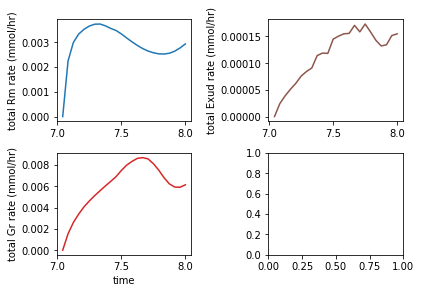

In [147]:
"""plot some results"""
fig, axs = plt.subplots(2,2)
axs[0,0].plot(time, Q_Rmall)
axs[0,0].set(xlabel='', ylabel='total Rm rate (mmol/hr)')
#axs[0].xaxis.set_major_locator(MaxNLocator(5))
axs[1,0].plot(time, Q_Grall, 'tab:red')
axs[1,0].set(xlabel='time', ylabel='total Gr rate (mmol/hr)')
#axs[1].xaxis.set_major_locator(MaxNLocator(5))
axs[0,1].plot(time, Q_Exudall , 'tab:brown')
axs[0,1].set(xlabel='', ylabel='total Exud rate (mmol/hr)')
#axs[2].xaxis.set_major_locator(MaxNLocator(5))
fig.tight_layout()
plt.show()

## Take away messages

* Basic idea how to use the class *PhloemFlow*
